In [178]:
import pandas as pd
import numpy as np

In [179]:
#preprocessed_df=pd.read_csv('/home/rootuser/arj/ticket/Data/preprocessed_data.csv')
preprocessed_df=pd.read_csv('Data/preprocessed_data.csv')
preprocessed_df.drop(['Unnamed: 0'],1,inplace=True)

In [180]:
preprocessed_df.head()

,Hostname,Application,Utilization(bps),Timestamp
0,vdevice-host-name,dns,105.000,2019-01-18 08:55:00
1,vdevice-host-name,tcp,0.000,2019-01-18 08:55:00
2,vdevice-host-name,https,2777.375,2019-01-18 08:55:00
3,vdevice-host-name,google_gen,0.000,2019-01-18 08:55:00
4,vdevice-host-name,firefox_update,0.000,2019-01-18 08:55:00


In [181]:
application_name=['dns','https']

In [182]:
# for i in application_name:
    
df=preprocessed_df.loc[preprocessed_df['Application'] == 'dns']
df=df[['Timestamp','Utilization(bps)']]
training_set=df[0:len(df)-150]
print(training_set.shape)
training_set_sliced = training_set.iloc[:, 1:2].values


(15982, 2)


In [183]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set_sliced)


In [184]:
# Creating a data structure with 100 timesteps and 1 output
X_train = []
y_train = []
for i in range(15, len(training_set)):
    X_train.append(training_set_scaled[i-15:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [185]:
X_train.shape

(15967, 15, 1)

In [186]:
y_train.shape

(15967,)

In [187]:

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

In [188]:

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, activation = 'relu' ,input_shape = (X_train.shape[1], 1)))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])





In [189]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 1000, batch_size = 10)

Epoch 1/1000
15967/15967 [==============================] - 18s 1ms/step - loss: 5.6449e-04 - acc: 2.5052e-04
Epoch 2/1000
15967/15967 [==============================] - 16s 988us/step - loss: 5.4070e-04 - acc: 2.5052e-04
Epoch 3/1000
15967/15967 [==============================] - 17s 1ms/step - loss: 5.3880e-04 - acc: 2.5052e-04
Epoch 4/1000
 5310/15967 [========>.....................] - ETA: 11s - loss: 5.4598e-04 - acc: 1.8832e-04

In [98]:
print('model built successfully')
#regressor.save('/home/rootuser/arj/ticket/model/dns-relu(1000 epo- 100 neuron-288 time).h5') 
regressor.save('model/dns-relu(1000 epo- 100 neuron-288 time).h5') 

model built successfully


In [173]:

real_pattern_prediction=df[len(df)-150:]

In [174]:
real_pattern_prediction.head()

,Timestamp,Utilization(bps)
583933,2019-03-14 11:00:00,1563.750
583984,2019-03-14 11:05:00,672.625
584047,2019-03-14 11:10:00,422.125
584131,2019-03-14 11:15:00,735.375
584189,2019-03-14 11:20:00,527.250


In [175]:
training_set.head()

,Timestamp,Utilization(bps)
0,2019-01-18 08:55:00,105.0
9,2019-01-18 09:00:00,212.5
20,2019-01-18 09:05:00,105.0
21,2019-01-18 09:10:00,340.0
34,2019-01-18 09:15:00,142.5


In [176]:

# Getting the Random predictiond data
dataset_total = pd.concat((training_set['Utilization(bps)'], real_pattern_prediction['Utilization(bps)']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(real_pattern_prediction) - 288:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(15, len(real_pattern_prediction)+15):
    X_test.append(inputs[i-15:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_pattern = regressor.predict(X_test)
predicted_pattern = sc.inverse_transform(predicted_pattern)

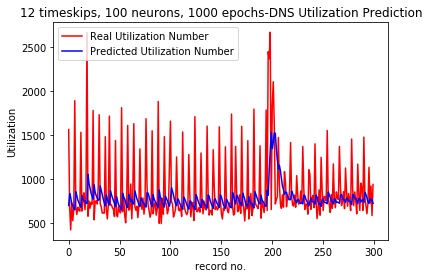

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline
real_pattern_prediction=real_pattern_prediction.iloc[:, 1:2].values
# Visualising the results
plt.plot(real_pattern_prediction, color = 'red', label = 'Real Utilization Number')
plt.plot(predicted_pattern, color = 'blue', label = 'Predicted Utilization Number')
plt.title('12 timeskips, 100 neurons, 1000 epochs-DNS Utilization Prediction')
plt.xlabel('record no.')
plt.ylabel('Utilization')
plt.legend()
plt.show()